# BDA522: Advance Machine Learning Term Project
<font size = 4.5 >Kutay Akalın </font>  
<font size = 4.5 >17/06/2020 </font>


In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from time import time
import librosa
import librosa.display
import missingno as msno
import IPython.display as ipd
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Project Definition

As BDA522: Advance Machine Learning term project, I would like to analyse sounds, extract the Mel-Frequency Cepstral Coefficients (MFCC) features and classify these sounds using Neural Networks. For this purpose, I used URBANSOUND8K dataset. This dataset consists of 8,000 sounds with 10 different labels; Air Conditioner, Car Horn, Children Playing, Dog bark, Drilling, Engine Idling, Gun Shot, Gun Shot, Jackhammer, Siren, and Street Music. You can find more information about the dataset by clicking [here](https://urbansounddataset.weebly.com/). 

# About Data


## Metadata

Metadata csv file includes information about our dataset.

In [ ]:
os.chdir('/content/drive/My Drive/Music Classification/UrbanSound8K/')
metadata = pd.read_csv("metadata/UrbanSound8K.csv")
print(metadata.shape)
print(metadata.info())

metadata

(8732, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB
None


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [ ]:
metadata.isna().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [ ]:
metadata.fold.value_counts(normalize=True)

4     0.113376
5     0.107192
3     0.105932
2     0.101695
1     0.099977
7     0.095969
10    0.095854
6     0.094251
9     0.093449
8     0.092304
Name: fold, dtype: float64

### Analyzing the MetaData with Facets



In [ ]:
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.3f}".format
from google.colab import widgets

from IPython.core.display import display, HTML
import base64
!pip install facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

In [ ]:
metadata.classID = metadata.classID.astype('object',copy=False)
metadata.fold = metadata.fold.astype('object',copy=False)
metadata.salience = metadata.salience.astype('object',copy=False)

fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': metadata, 'name': 'MetaData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

# Audio Analysis

Before extracting the MFCC features of the sounds, I would like give example about Audio Signal Processing. For extracting the features from audios, we need to covert analog signal into digital signal. For this transformation, Discrete Fourier Transform (DFT) and Short-time Fourier Transform (STFT) should be used. Librosa python package is very useful for analysing the audios and extracting the different type of features from them. Thus, in this section, I analysed a one sound with label `street_music` and  `dog_bark` using Librosa functions. `librosa.load` converts the sampling rate to 22.05 KHz by default, normalise the data so the bit-depth values range between -1 and 1 and flattens the audio channels into mono.

In [ ]:
os.chdir('/content/drive/My Drive/Music Classification/UrbanSound8K/audio')
y,sr = librosa.load("fold1/108041-9-0-9.wav",sr=44100)
ipd.display(ipd.Audio(data=y, rate=sr))

Example of dog bark:

In [ ]:
y2,sr2 = librosa.load("fold5/100032-3-0-0.wav",sr=44100)
ipd.display(ipd.Audio(data=y2, rate=sr2))

## Wave Format

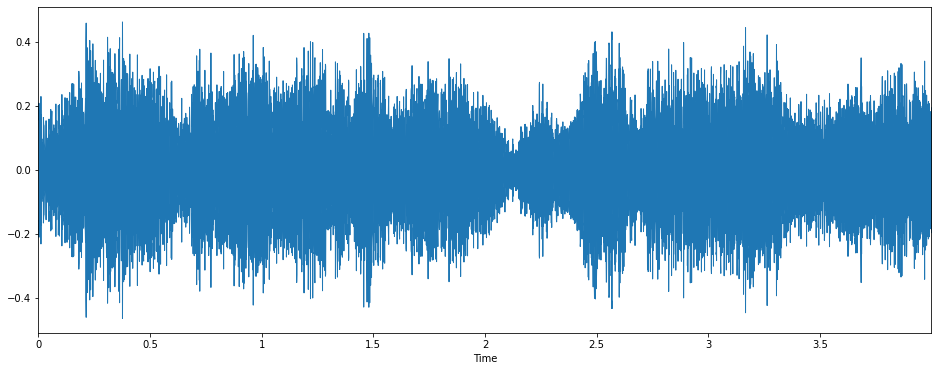

In [ ]:
plt.figure(figsize=( 16, 6))
librosa.display.waveplot(y, sr=sr)

Example of dog bark:

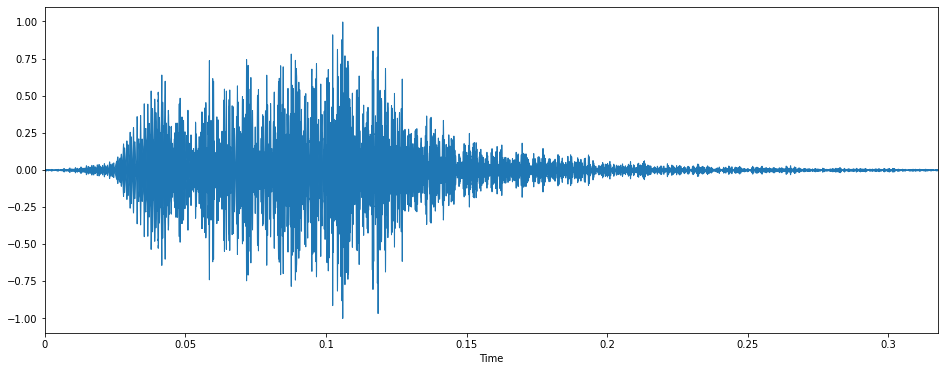

In [ ]:
plt.figure(figsize=( 16, 6))
librosa.display.waveplot(y2, sr=sr2)

##STFT

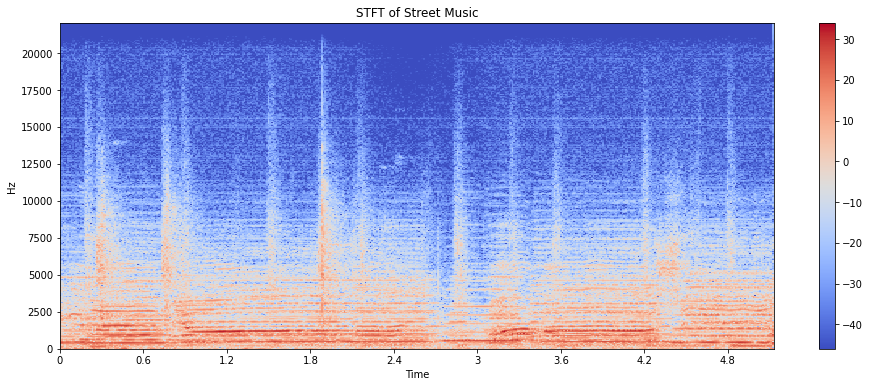

In [ ]:
X = librosa.stft(y, n_fft=2048, hop_length=400, win_length=801, window='hann')
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(16, 6))
plt.title('STFT of Street Music')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

Example of dog bark:

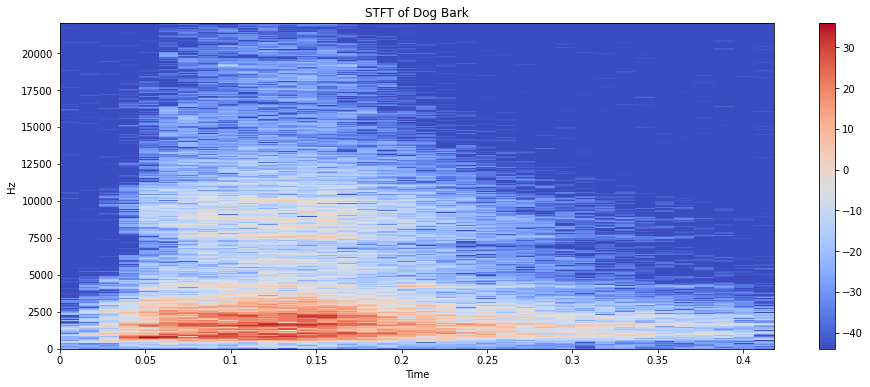

In [ ]:
X2 = librosa.stft(y2, n_fft=2048, hop_length=400, win_length=801, window='hann')
Xdb2 = librosa.amplitude_to_db(abs(X2))
plt.figure(figsize=(16, 6))
plt.title('STFT of Dog Bark')
librosa.display.specshow(Xdb2, sr=sr2, x_axis='time', y_axis='hz')
plt.colorbar()

## MFFC

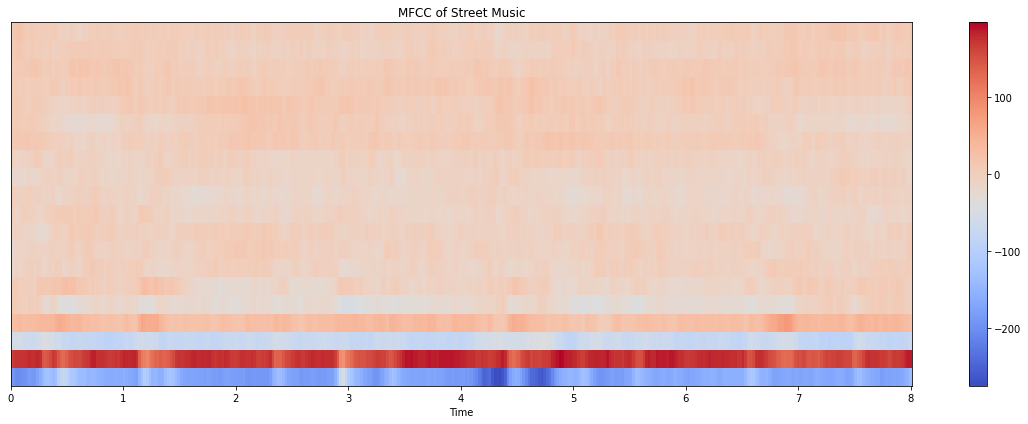

In [ ]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)
mfccs
plt.figure(figsize=(16, 6))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC of Street Music')
plt.tight_layout()
plt.show()

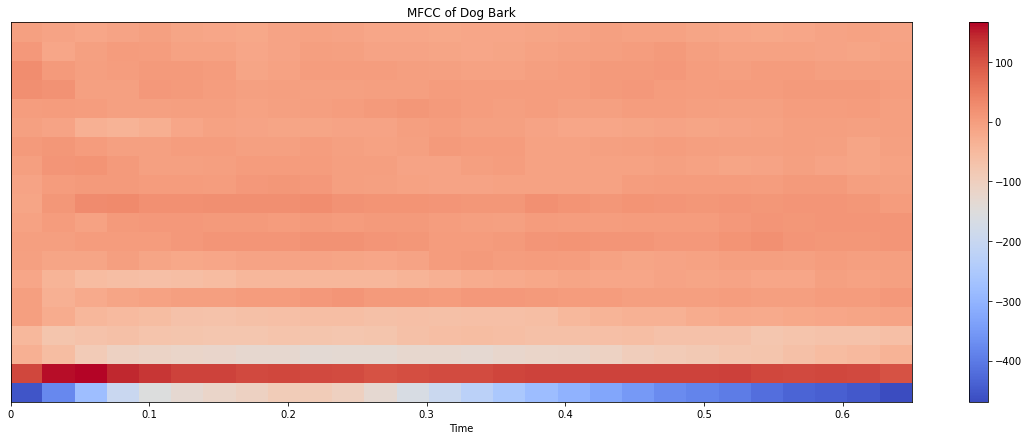

In [ ]:
mfccs2 = librosa.feature.mfcc(y=y2, sr=sr2)
mfccs
plt.figure(figsize=(16, 6))
librosa.display.specshow(mfccs2, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.title('MFCC of Dog Bark')
plt.show()

## Chroma Features


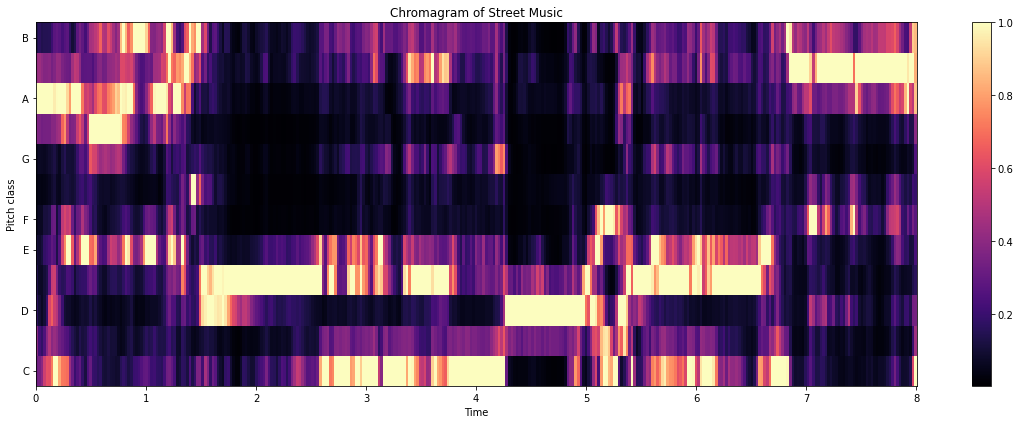

In [ ]:
chroma = librosa.feature.chroma_stft(ys,srs)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram of Street Music')
plt.tight_layout()
plt.show()

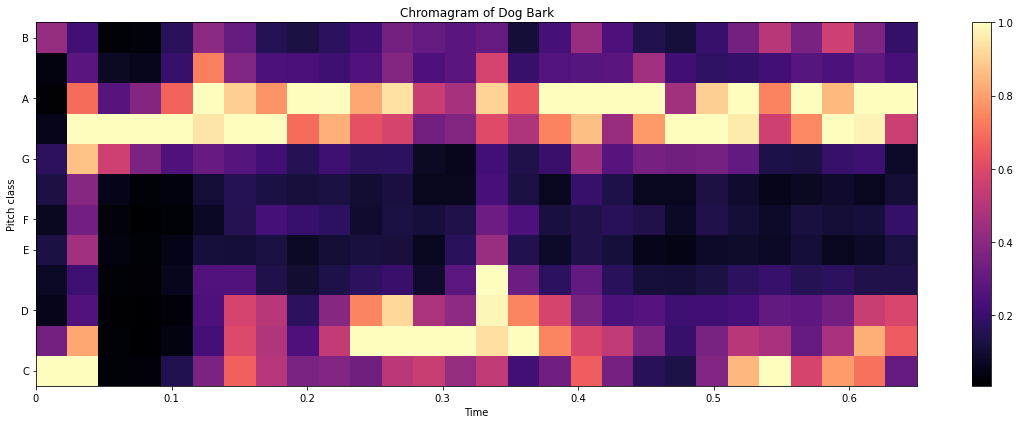

In [ ]:
chroma2 = librosa.feature.chroma_stft(y2,sr2)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram of Dog Bark')
plt.tight_layout()
plt.show()

# Reading Audio Files

For each sound on the dataset, I read files and extract their 40 MFCC values using `librosa.feature.mfcc` function.

In [ ]:
os.chdir('/content/drive/My Drive/Music Classification/UrbanSound8K/audio/')

basepath = os.getcwd()
features_df = pd.DataFrame({"slice_file_name": "", "MFCC": [[1,2,3,4,5]]})

for entry in os.listdir(basepath):

  if os.path.isdir(os.path.join(basepath, entry)):
    start = time()  
    tmp = os.path.join(basepath, entry)
    for file in os.listdir( tmp ):
      if file.endswith( ".wav" ):
        try:
          tmp2 = os.path.join( tmp, file)
          y,sr = librosa.load(tmp2,sr =44100,res_type='kaiser_fast')
          mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)
          feature = np.mean(mfccs.T,axis=0)
          tmp3 = pd.DataFrame({"slice_file_name": file, "MFCC": [feature]})
          features_df=features_df.append(tmp3)
        except Exception as e:
          print(file,e)
          continue
    finish = time()
    print(entry,"is finished.")
    print("Current length of dataframe:",features_df.shape[0])
    print("Time pass:", finish-start,"\n")
    


fold10 is finished.
Current length of dataframe: 838
Time pass: 179.82208681106567 /n
fold2 is finished.
Current length of dataframe: 1726
Time pass: 193.44267344474792 /n
fold3 is finished.
Current length of dataframe: 2651
Time pass: 176.2686972618103 /n
fold5 is finished.
Current length of dataframe: 3587
Time pass: 193.12410354614258 /n
fold6 is finished.
Current length of dataframe: 4410
Time pass: 157.7438931465149 /n
fold7 is finished.
Current length of dataframe: 5248
Time pass: 212.58033680915833 /n
194733-9-0-12.wav ffmpeg output: 
fold8 is finished.
Current length of dataframe: 6053
Time pass: 897.0750267505646 /n
fold9 is finished.
Current length of dataframe: 6869
Time pass: 866.3659200668335 /n
103074-7-3-2.wav ffmpeg output: 
fold1 is finished.
Current length of dataframe: 7741
Time pass: 1030.5493841171265 /n
fold4 is finished.
Current length of dataframe: 8731
Time pass: 983.4061181545258 /n


In [ ]:
features_df

,slice_file_name,MFCC
0,,"[1, 2, 3, 4, 5]"
0,178261-7-3-1.wav,"[-133.39517567010682, 88.82336392450432, -5.49..."
0,178261-7-3-0.wav,"[-132.9964864750382, 88.36935818939271, -5.451..."
0,174292-6-0-0.wav,"[-395.544543358727, 93.4582039233194, -9.95374..."
0,178261-7-2-0.wav,"[-128.8217012446833, 86.07044685805651, -11.04..."
...,...,...
0,132016-7-0-5.wav,"[-302.6668802847412, 181.20674656279624, -21.8..."
0,131428-9-1-9.wav,"[-376.98633739927953, 171.30454248898815, 24.7..."
0,132016-7-0-2.wav,"[-269.9262100683649, 166.48679146921398, -21.4..."
0,132016-7-0-6.wav,"[-312.36773161279086, 180.57657315654885, -19...."


In [ ]:
features_df=features_df.reset_index(drop=True).loc[1:,:]
all_df = pd.merge(metadata,features_df,on="slice_file_name")
all_df

,slice_file_name,fsID,start,end,salience,fold,classID,class,MFCC
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,"[-275.1182161345705, 119.94201414467918, -98.5..."
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,"[-500.9422043472262, 185.2790942662163, -86.73..."
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,"[-531.3129833303144, 187.20842602015847, -70.5..."
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,"[-476.6883425505642, 160.30865668328252, -62.9..."
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,"[-521.3388932202635, 185.59744923638254, -82.1..."
...,...,...,...,...,...,...,...,...,...
8725,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,"[-466.5238432093275, 193.29718297399106, -63.9..."
8726,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,"[-396.6243965743338, 134.84552503864276, -64.9..."
8727,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,"[-362.7312356536671, 165.22362660492945, -60.9..."
8728,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,"[-404.53457783907027, 178.5947199385138, -63.7..."


# Classification using Neural Networks

Because of the time cost, I saved the `features_df` into Google drive as `merge_df.csv` and read this file for deep learning approach. 

In [ ]:
os.chdir('/content/drive/My Drive/Music Classification/')

data = pd.read_csv('merge_df.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8730 entries, 0 to 8729
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8730 non-null   object 
 1   fsID             8730 non-null   int64  
 2   start            8730 non-null   float64
 3   end              8730 non-null   float64
 4   salience         8730 non-null   int64  
 5   fold             8730 non-null   int64  
 6   classID          8730 non-null   int64  
 7   class            8730 non-null   object 
 8   0                8730 non-null   float64
 9   1                8730 non-null   float64
 10  2                8730 non-null   float64
 11  3                8730 non-null   float64
 12  4                8730 non-null   float64
 13  5                8730 non-null   float64
 14  6                8730 non-null   float64
 15  7                8730 non-null   float64
 16  8                8730 non-null   float64
 17  9             

## MFCCs Densities

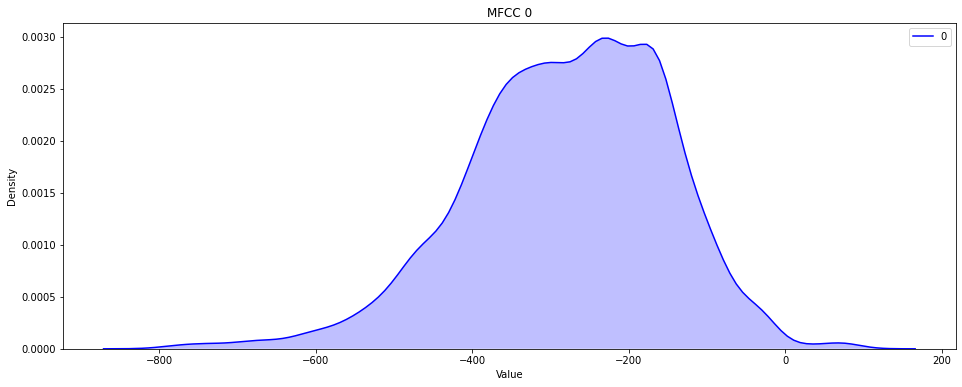

In [ ]:
plt.figure(figsize=(16, 6))
plt.title('MFCC 0')
plt.xlabel("Value")
plt.ylabel("Density")
sns.kdeplot(data["0"], shade=True, color="b")

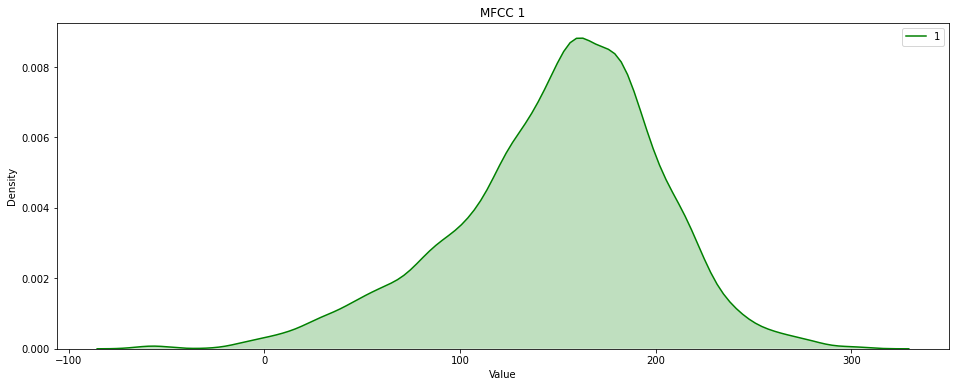

In [ ]:
plt.figure(figsize=(16, 6))
plt.title('MFCC 1')
plt.xlabel("Value")
plt.ylabel("Density")
sns.kdeplot(data["1"], shade=True, color="g")

## Pre-Processing

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

preprocess = data.iloc[:,8:]

p1 = [preprocess.iloc[0,:40].tolist()]
for x in range(1,preprocess.shape[0]):
  p1.append(preprocess.iloc[x,:40].tolist())

X = np.array(p1)
y = np.array(data.classID.tolist())
y2 = to_categorical(y)

norm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(norm, y2, test_size=0.15, random_state = 127)

## Function Definiton

In [ ]:
#Plotting Function
def plot_curve(epochs, hist, list_of_metrics):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

In [ ]:
#Model and Train Functions

import tensorflow as tf
from tensorflow.keras import layers

def create_model(my_learning_rate):
  """Create and compile a deep
   neural net."""
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=256, input_shape=(40,)))
  model.add(tf.keras.layers.Dense(units=256, activation='relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(units=256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(units=128, activation='tanh'))
  model.add(tf.keras.layers.Dropout(rate=0.3))
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))  
                           

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="categorical_crossentropy",
                metrics=['accuracy',
                         tf.keras.metrics.AUC(name="auc"),
                         tf.keras.metrics.Precision(name="precision")])
  
  return model  


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist

## Model Building

Epoch 1/400
2/2 [==============================] - 0s 225ms/step - loss: 3.4947 - accuracy: 0.1051 - auc: 0.5224 - precision: 0.1101 - val_loss: 2.9933 - val_accuracy: 0.2188 - val_auc: 0.5832 - val_precision: 0.7692
Epoch 2/400
2/2 [==============================] - 0s 26ms/step - loss: 3.1702 - accuracy: 0.1482 - auc: 0.5750 - precision: 0.1843 - val_loss: 2.6462 - val_accuracy: 0.1349 - val_auc: 0.6179 - val_precision: 1.0000
Epoch 3/400
2/2 [==============================] - 0s 25ms/step - loss: 2.9704 - accuracy: 0.1346 - auc: 0.5767 - precision: 0.1858 - val_loss: 2.5129 - val_accuracy: 0.1947 - val_auc: 0.6493 - val_precision: 1.0000
Epoch 4/400
2/2 [==============================] - 0s 23ms/step - loss: 2.8120 - accuracy: 0.1510 - auc: 0.5994 - precision: 0.2029 - val_loss: 2.4170 - val_accuracy: 0.1578 - val_auc: 0.6442 - val_precision: 1.0000
Epoch 5/400
2/2 [==============================] - 0s 26ms/step - loss: 2.7319 - accuracy: 0.1527 - auc: 0.5915 - precision: 0.2149 - v

[0.27968764305114746,
 0.9461626410484314,
 0.9929910898208618,
 0.9482758641242981]

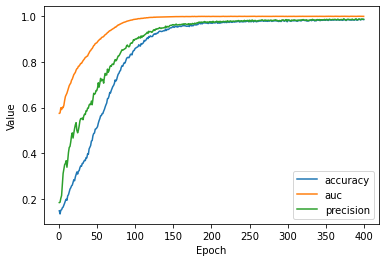

In [ ]:
# Hyperparameter tuning
learning_rate = 0.003
epochs = 400
batch_size = 4000
validation_split = 0.1


# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, X_train, y_train, 
                           epochs, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy','auc','precision']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=X_test, y=y_test, batch_size=batch_size)

In [ ]:
my_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 256)               10496     
_________________________________________________________________
dense_81 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)             

# Conclusion

## Confusion Matrix

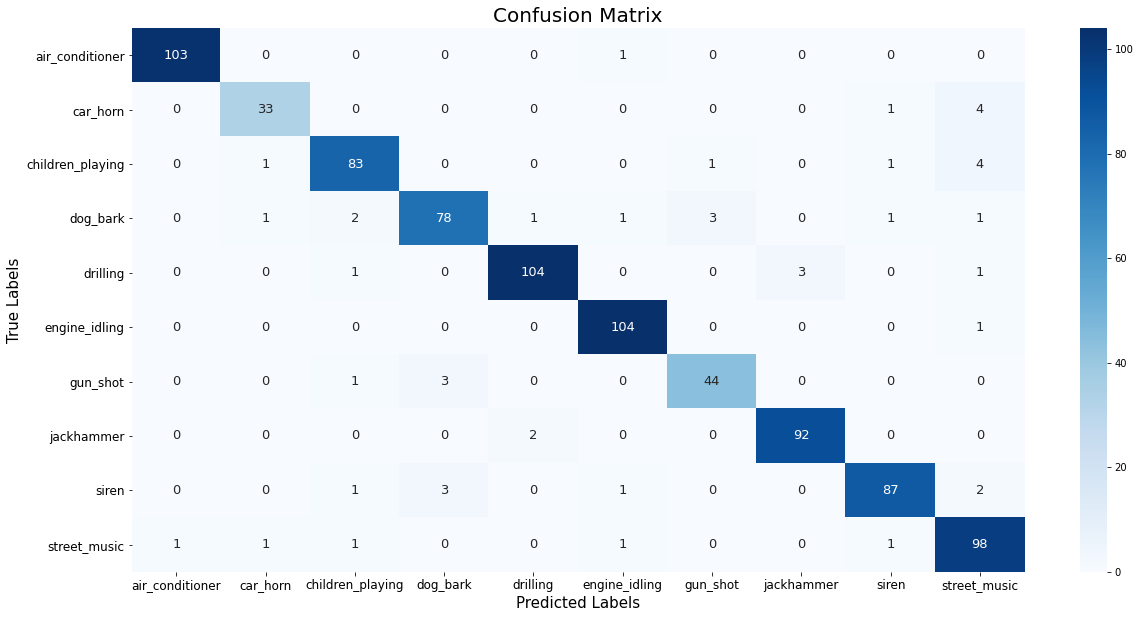

In [ ]:
y_pred = my_model.predict(X_test)
conf=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

labels = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer",
          "siren", "street_music"]
        
plt.figure(figsize=(20, 10))
ax = sns.heatmap(conf, annot=True,cmap='Blues',fmt='g',annot_kws={"size": 13})
ax.set_xlabel('Predicted Labels',fontsize = 15)
ax.set_ylabel('True Labels',fontsize = 15)
ax.set_title('Confusion Matrix',fontsize = 20)
ax.xaxis.set_ticklabels(labels, fontsize = 12)
ax.yaxis.set_ticklabels(labels, fontsize = 12, rotation=0)
plt.show()

We see that our deep learning algorithm performs very well on classifying sounds in our dataset. Train accuracy is %98.53 and test accuracy is %94.62. Both AUC values really are high. If we check the confusion matrix, we see that deep learning algorithm classified each label almost perfectly. However, it made mistakes when predict street music. Approximately, %11.7 of street music predictions are wrong. But , overall performance is still good enough. 